In [72]:
import numpy as np
import matplotlib.pyplot as plt
import math
import rpyc
import time
from IPython import display
import time
from sklearn.linear_model import LinearRegression

In [73]:
try:
    ROBOT_HOSTNAME = "ev3dev.local"
    conn = rpyc.classic.connect(ROBOT_HOSTNAME)
    conn.execute("print('Hello Slave. I am your master!')")
except:
    raise Exception('No conection to rpyc server on robot possible! Is the robot conneced? Is the rpyc server started?')
    


# Robot controls


### Movement speed:
Let $p$ be current leg position, $p'$ the requested leg position. We move the leg with speed $s$, where we select $s$ as a function of the distance to travel and the max speed.
$$
s = \frac{|p - p'|}{2} s-{max} \\
s_{min} \leq s \leq s_{max}
$$
We choose $s_{max} = 80\%$ of the maximum speed the motors are capable of. To ensure that there is some movement, se set a lower bound $s_{min} = 3\%$. 

### Robot reset
To determine when the robot comes to a standstill, we measure robot acceleration over a 3 second rolling time window. On these windows we perform linear regression, to determine the change in acceleration. If the change is near zero, the acceleration is constant and we assume the robot to be standing still.

Due to the inaccuracy of the gyroscope, using acceleration for this has been more successfull than measuring angle.


In [93]:
class RobotController:
    """
    The robot controller class.
    """
    def __init__(self, connection):
        motor_module = connection.modules['ev3dev2.motor']
        self.motors = [motor_module.LargeMotor('outB'), motor_module.LargeMotor('outC')]
        sensors = conn.modules['ev3dev2.sensor.lego'] 
        self.gyro = sensors.GyroSensor('in2')
        
        self.motors[0].stop_action = 'hold'
        self.motors[1].stop_action = 'coast'
        
        self.up_position_degrees = -90 # position of legs fully in front
        self.maxspeed = 80 # maximum speed of leg movement
        self.minspeed = 3 # minimum speed of leg movement
        self.angle_normalizer = 0.01
        self.rate_normalizer = 0.01
        
        
    
    def reset(self):
        """ resets the robot, performs calibration and maintainance, return when robot is reset.
        Called at the start of each episode"""
        # move legs to base position
        self._move_motors_to_pos(0, 20)
        self._wait_until_no_standstill(tolerance = 0.05)
        _, angle = self.get_rate_and_angle()
        if abs(angle) >= 0.04:
            # drifted pretty far, recalibrate
            self._wait_until_no_standstill(tolerance = 0.01)
            self._calibrate_gyro()
            return
    
    def get_rate_and_angle(self):
        """ returns the rate and angle of the robot movement"""
        angle, rate = self.gyro.rate_and_angle
        return (rate * self.rate_normalizer, angle * self.angle_normalizer)

    def get_current_leg_pos(self):
        """ returns the curent leg pos, on a [-1, 1] interval"""
        return self.motors[0].position /  self.up_position_degrees
    
    def move_legs(self, pos):
        """ instructs the robot where to move its legs to, on a [-1, 1] interval. Function returns immediatly."""
        pos = max(-1., min(pos, 1.))
        pos_now = self.get_current_leg_pos()
        
        s = abs(pos - pos_now) / 2 *  self.maxspeed
        s = max(self.minspeed, min(s,  self.maxspeed))
        
        self._move_motors_to_pos(pos, s)
        return
    
    def _move_motors_to_pos(self, pos, speed):
        """
        moves the motors to a position [-1, 1] at speed [0,100].
        """
        assert -1. <= pos <= 1.,\
                    "{} is an invalid position, must be between -1 and 1 (inclusive)".format(pos)
        assert 0. <= speed <= 100.,\
                    "{} is an invalid position, must be between -1 and 1 (inclusive)".format(pos)
        
        self.motors[0].on_to_position(speed, position=pos*self.up_position_degrees, brake=True, block=False) # moves motors, non blocking.
        return
            
            
    def _calibrate_gyro(self):
        print('calibrating gyro')
        self.gyro.mode='GYRO-CAL'
        time.sleep(1)
        self.gyro.mode="GYRO-ANG"
        
    def _wait_until_no_standstill(self, tolerance=0.01):
        """
        waits until the gyro acceleration does not change for 3 seconds
        """
        print("Waiting to stand still.")
        change = 9999
        while abs(change) > tolerance: 

            rates = []
            times = []
            # sample for one second
            t0 = t = time.time()
            while t - t0 < 3:
                _, rate = self.gyro.rate_and_angle
                rates.append(rate)
                t = time.time()
                times.append(t)


            # check change in accel with linreg
            rates = abs(np.array(rates)) # take absolute rates so swinging doesnt cancel each other out
            times = np.array(times)
            lr = LinearRegression()
            lr.fit(times[:, np.newaxis], rates)  
            change = lr.coef_

        return

class RobotControllerVerboseWrapper(RobotController):
    """
    Wrapper / decorator for the robot controller to add verbose logging
    for design pattern see https://github.com/faif/python-patterns/blob/master/structural/decorator.py
    """
    def __init__(self, robotController):
        self.wrapped = robotController
        self.last_move = time.time()
        
    def reset(self):
        return self.wrapped.reset()
    
    def get_rate_and_angle(self):
        return self.wrapped.get_rate_and_angle()
    
    def get_current_leg_pos(self):
        return self.wrapped.get_current_leg_pos()
    
    def move_legs(self, pos):
        print("Moving legs to {}, time since last move {}".format(pos, time.time() - self.last_move))
        self.last_move = time.time()
        return self.wrapped.move_legs(pos)

class RobotControllerExceptionWrapper(RobotController):
    """
    Wrapper / decorator for the robot controller to handle time out exceptions
    for design pattern see https://github.com/faif/python-patterns/blob/master/structural/decorator.py
    """
    def __init__(self, robotController):
        self.wrapped = robotController
        
    def reset(self):
        try:
            return self.wrapped.reset()
        except TimeoutError:
            print('TimeoutError occured! retrying...')
            time.sleep(3)
            return self.reset()
    
    def get_rate_and_angle(self):
        try:
            return self.wrapped.get_rate_and_angle()
        except TimeoutError:
            print('TimeoutError occured! retrying...')
            time.sleep(3)
            return self.get_rate_and_angle()
    
    def get_current_leg_pos(self):
        try:
            return self.wrapped.get_current_leg_pos()
        except TimeoutError:
            print('TimeoutError occured! retrying...')
            time.sleep(3)
            return self.get_current_leg_pos()
    
    def move_legs(self, pos):
        try:
            return self.wrapped.move_legs(pos)
        except TimeoutError:
            print('TimeoutError occured! retrying...')
            time.sleep(3)
            return self.move_legs(pos)
            
        

In [76]:
rc = RobotController(conn)

In [91]:
rc.move_legs(0)

In [80]:
rc.get_rate_and_angle()

(0.0, 0.0)

In [83]:
t0 = time.time()

while time.time() - t0 < 10:
    rate, angle = rc.get_rate_and_angle()
    
    display.clear_output(wait=True)
    display.display("angle: {} \n rate:  {}".format(angle, rate))

'angle: 0.0 \n rate:  -0.01'

# Validation Experiment
We reset the robot, then move the legs forward and plot the result

In [85]:
rc = RobotController(conn)
rc.reset()

timesteps = []
angles = []
speed= []

rc.move_legs(1)

t0 = time.time()

while time.time() - t0 < 20:
    rate, angle = rc.get_rate_and_angle()
    t = time.time() - t0
    timesteps.append(t)
    angles.append(angle)
    speed.append(rate)

Waiting to stand still.


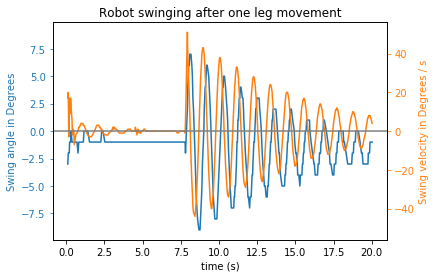

In [86]:
timesteps = np.array(timesteps)
angles = np.array(angles) / rc.angle_normalizer
maxangle = max(abs(angles))
speed= np.array(speed) / rc.rate_normalizer
maxspeed = max(abs(speed))

c0 = '#1f77b4'
c1 = '#ff7f0e'
fig, ax1 = plt.subplots()
ax1.plot(timesteps, angles, label="Swing Angle in Degrees", color=c0)
ax1.set_xlabel('time (s)')
ax1.set_ylabel('Swing angle in Degrees', color=c0)
ax1.tick_params('y', colors=c0)
ax1.set_ylim(-maxangle * 1.1 , maxangle * 1.1)
ax2 = ax1.twinx()
ax2.plot(timesteps, speed, label="Swing Velocity, in degrees / s", color=c1)
ax2.set_ylabel('Swing velocity in Degrees / s', color=c1)
ax2.tick_params('y', colors=c1)
ax2.set_ylim(-maxspeed * 1.1, maxspeed * 1.1)
plt.axhline(0, color='gray')
plt.xlabel("time $t$ in s")
plt.title('Robot swinging after one leg movement')
plt.savefig('pendulum.pdf')
plt.show()

# Manual swing motion

In [87]:
rc = RobotController(conn)

In [88]:
rc.reset()
angles = []
times = []
t0 = time.time()
while time.time() < t0 + 30:
    rate, angle = rc.get_rate_and_angle()
    pos = np.sign(rate)
    pos = pos if pos != 0 else 1
    rc.move_legs(pos)
    angles.append(angle)
    times.append(time.time())

Waiting to stand still.


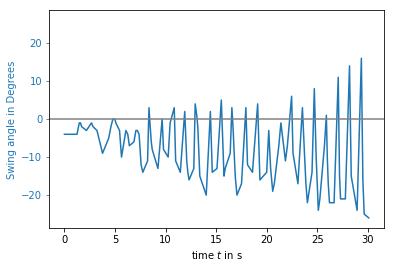

In [89]:
times = np.array(times) - times[0]
angles = np.array(angles) / rc.angle_normalizer
maxangle = max(abs(angles))

c0 = '#1f77b4'
c1 = '#ff7f0e'
fig, ax1 = plt.subplots()
ax1.plot(times, angles, label="Swing Angle in Degrees", color=c0)
ax1.set_xlabel('time (s)')
ax1.set_ylabel('Swing angle in Degrees', color=c0)
ax1.tick_params('y', colors=c0)
ax1.set_ylim(-maxangle * 1.1 , maxangle * 1.1)
plt.axhline(0, color='gray')
plt.xlabel("time $t$ in s")
plt.savefig('pendulum.pdf')
plt.show()

In [90]:
times[-1] / len(times)

0.28644497735159735